# Correlaciones fisiologicas y acusticas: voces hipofuncionales vs hiperfuncionales

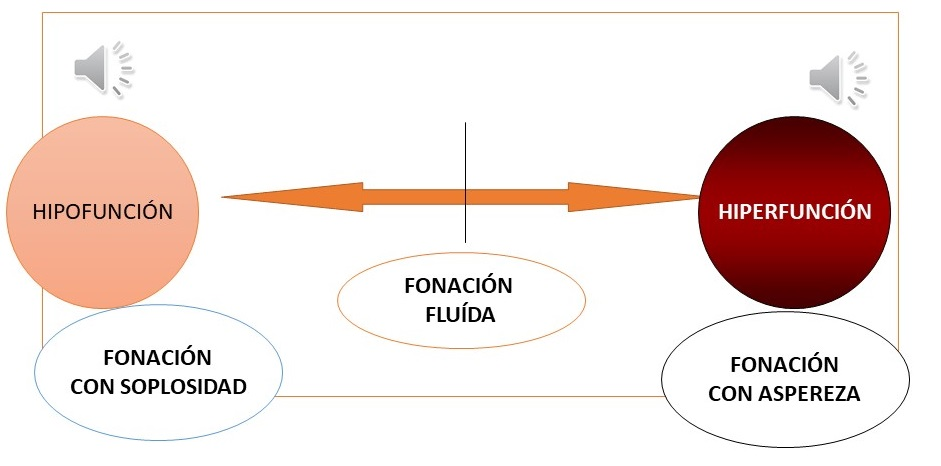

In [1]:
# Mostrar el resultado de cada línea de la misma celda
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# importar librerias generales
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow
import keras

# importar caracteristicas de librerias
from matplotlib import colors 
from sklearn.metrics import classification_report, confusion_matrix, r2_score, mean_squared_error, precision_score, recall_score, f1_score, cohen_kappa_score
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score, GridSearchCV,RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, SelectFpr
from sklearn.preprocessing import scale, StandardScaler, normalize, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LogisticRegression, ElasticNet
from scipy.stats import randint
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD, RMSprop
from scipy.signal import spectrogram, gaussian
from matplotlib.cm import get_cmap

from keras.regularizers import l2, l1, l1_l2
from keras.layers import Dropout
from keras import backend as K
from matplotlib import pyplot
from pandas import DataFrame
import time
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor

# importar librerias de procesamiento de voz
import scipy.signal
import scipy.io.wavfile
from signals import*
import parselmouth


Using TensorFlow backend.


### Captura de audio

In [2]:
plt.rc('figure', figsize=(16, 4))
# Leer archivo de audio y obtener la frecuencia de muestreo y el numero de muestras
sampling_frequency, wav_data = scipy.io.wavfile.read('prueba2.wav')

# Convertir la información de audio a tipo flotante
def convert_wav_to_float(data):
    if data.dtype == np.uint8:
        data = (data - 128) / 128.
    elif data.dtype == np.int16:
        data = data / 32768.
    elif data.dtype == np.int32:
        data = data / 2147483648.
    return data

wav_data = convert_wav_to_float(wav_data)

### Obtención frecuencia de muestreo y numero de muestras del audio de entrada

In [3]:
print("Frecuencia de muestreo: "+" "+str(sampling_frequency)+" Hz")
print("Tamaño de muestras del archivo de audio: "+" "+str(wav_data.shape))

Frecuencia de muestreo:  44100 Hz
Tamaño de muestras del archivo de audio:  (225307, 2)


### Grafica de señal de audio de entrada

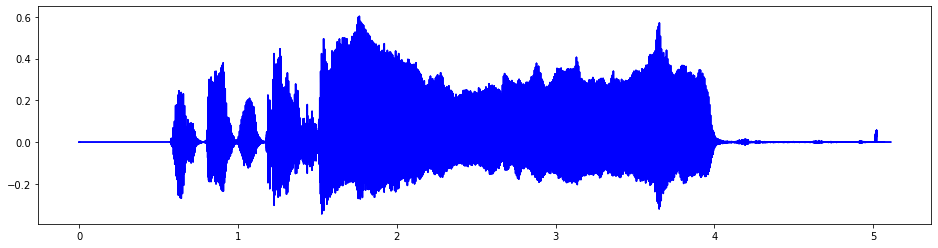

In [4]:
# numero total de datos del audio
n_samples = len(wav_data)
# duracion del audio en segundos
total_duration = n_samples / sampling_frequency
# generar cantidad de tiempos dependiendo el numero de muestras 
sample_times = np.linspace(0, total_duration, n_samples)
# graficar las muestras respecto al tiempo
plt.plot(sample_times, wav_data, color='b')

In [5]:
#calculo duracion de audio
print(f"Duración de audio: {len(wav_data)/sampling_frequency} segundos")
duration= len(wav_data)/sampling_frequency

Duración de audio: 5.109002267573696 segundos


### Calculo del cepstrum

In [6]:
# función para calcular el cepstrum de un audio
def real_cepstrum(x, n=None):
    spectrum = np.fft.fft(x, n=n) 
    ceps = np.fft.fft((np.abs(spectrum))).real
    ceps = np.log(ceps)
    return ceps

### Gráfica del cepstrum de la señal de audio 

C:\Users\Anfeguar\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """


Text(0.5, 0, 'time in seconds')

Text(0.5, 0, 'quefrency in seconds')

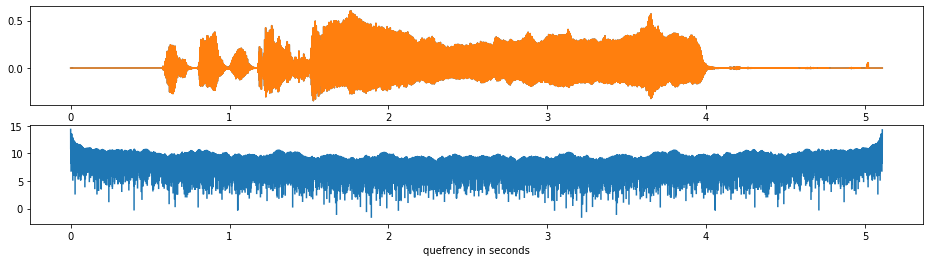

In [7]:
# obtener el valor de cepstrum
ceps = real_cepstrum(wav_data[:,0])

# graficar audio original y audio con cepstrum
fig = plt.figure()
ax0 = fig.add_subplot(211)
ax0.plot(sample_times, wav_data)
ax0.set_xlabel('time in seconds')
ax1 = fig.add_subplot(212)
ax1.plot(sample_times, ceps)
ax1.set_xlabel('quefrency in seconds')

### Valor máximo del cepstrum

In [8]:
# calculo de valor maximo de cepstrum
val_cepstrum=np.nanmax(ceps)
print("Valor pico de cepstrum: "+" "+str(val_cepstrum))

Valor pico de cepstrum:  14.354366335657595


### Cálculo relación harmónico - ruido

In [9]:
# calculo de HNR con un rate fijo
rate = 50000
val_HNR=get_HNR(wav_data[:,0], rate)
print("Valor de HNR: "+" "+str(val_HNR))

Valor de HNR:  15.613104593608966


### Cálculo y visualización de espectograma e intensidad

In [10]:
# función para calcular el espectrograma del audio de entrada
def draw_spectrogram(spectrogram, dynamic_range=70):
    X, Y = spectrogram.x_grid(), spectrogram.y_grid()
    sg_db = 10 * np.log10(spectrogram.values)
    plt.pcolormesh(X, Y, sg_db, vmin=sg_db.max() - dynamic_range, cmap='afmhot')
    plt.ylim([spectrogram.ymin, spectrogram.ymax])
    plt.xlabel("time [s]")
    plt.ylabel("frequency [Hz]")

# función para calcular la intesidad en dB del audio
def draw_intensity(intensity):
    plt.plot(intensity.xs(), intensity.values.T, linewidth=3, color='w')
    plt.plot(intensity.xs(), intensity.values.T, linewidth=1)
    plt.grid(False)
    plt.ylim(0)
    plt.ylabel("intensity [dB]")

<Figure size 1152x288 with 0 Axes>

(0.0, 5.109002267573696)

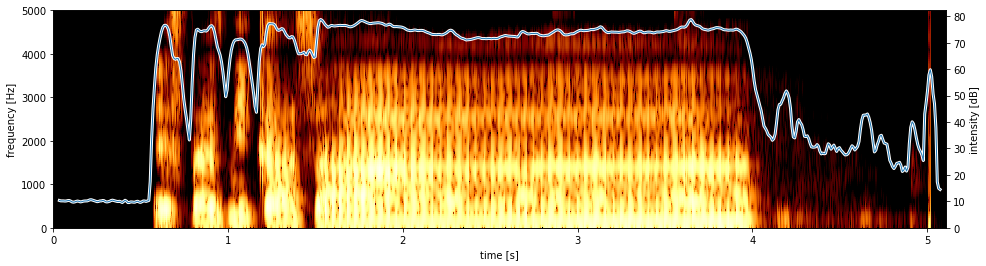

In [11]:
# tomar la señal de sonido para obtener espectogramas
snd = parselmouth.Sound('prueba2.wav')

# calculo de la intesidad del audio
intensity = snd.to_intensity()
# calculo del espectograma
spectrogram = snd.to_spectrogram()
# graficar espectograma e intensidad
plt.figure()
draw_spectrogram(spectrogram)
plt.twinx()
draw_intensity(intensity)
plt.xlim([snd.xmin, snd.xmax])
plt.show()

### Cálculo y visualización del pitch

In [12]:
# función para calcular el pitch (frecuencia fundamental)
def draw_pitch(pitch):
    # Extract selected pitch contour, and
    # replace unvoiced samples by NaN to not plot
    pitch_values = pitch.selected_array['frequency']
    pitch_values[pitch_values==0] = np.nan
    plt.plot(pitch.xs(), pitch_values, 'o', markersize=5, color='w')
    plt.plot(pitch.xs(), pitch_values, 'o', markersize=2)
    plt.grid(False)
    plt.ylim(0, pitch.ceiling)
    plt.ylabel("fundamental frequency [Hz]")

<Figure size 1152x288 with 0 Axes>

(0.0, 5.109002267573696)

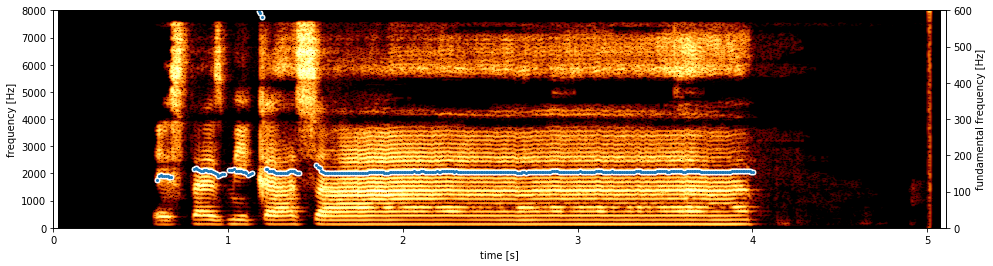

In [13]:
# obtención del pitch
pitch = snd.to_pitch()
# calculo del espectograma con una frecuencia maxima de 8000 Hz
pre_emphasized_snd = snd.copy()
pre_emphasized_snd.pre_emphasize()
spectrogram = pre_emphasized_snd.to_spectrogram(window_length=0.03, maximum_frequency=8000)
# grafica de espectograma y pitch
plt.figure()
draw_spectrogram(spectrogram)
plt.twinx()
draw_pitch(pitch)
plt.xlim([snd.xmin, snd.xmax])
plt.show()

### Obtención de datos para Hiper / Hipo 

In [14]:
# importar datos hiperfuncionales de excel
Hiper=pd.read_excel('DataSet_Hiperfuncionales.xlsx')
# mostrar tamaño de datos
Hiper.shape
# mostrar los 5 primeros valores de la tabla de datos
Hiper.head()

(29, 5)

,EGG,PSUB,PTP,CPP,HNR
0,54.000000,9.466667,5.400000,30.370000,26.536333
1,48.666667,7.000000,5.033333,24.006667,16.855667
2,51.333333,6.566667,4.933333,28.010000,22.003000
3,45.000000,8.633333,5.400000,30.260000,19.990333
4,51.666667,7.433333,5.700000,29.843333,12.299000


In [15]:
# importar datos hipofuncionales de excel
Hipo=pd.read_excel('DataSet_Hipofuncionales.xlsx')
# mostrar tamaño de datos
Hipo.shape
# mostrar los 5 primero valores de la tabla de datos
Hipo.head()

(26, 5)

,EGG,PSUB,PTP,CPP,HNR
0,46.600000,6.166667,4.600000,14.720000,12.558000
1,58.000000,7.566667,6.566667,18.220000,10.527667
2,40.333333,7.600000,5.700000,29.633333,20.422333
3,35.333333,6.800000,4.400000,24.743333,15.233333
4,43.000000,7.800000,7.566667,20.216667,15.523333


In [16]:
# mostrar informacion de las variables hiperfuncionales
Hiper.info()
print ('___________________')
# mostrar informacion de las variables hipofuncionales
Hipo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29 entries, 0 to 28
Data columns (total 5 columns):
EGG     29 non-null float64
PSUB    29 non-null float64
PTP     29 non-null float64
CPP     29 non-null float64
HNR     29 non-null float64
dtypes: float64(5)
memory usage: 1.3 KB
___________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 5 columns):
EGG     26 non-null float64
PSUB    26 non-null float64
PTP     26 non-null float64
CPP     26 non-null float64
HNR     26 non-null float64
dtypes: float64(5)
memory usage: 1.1 KB


In [17]:
# mostrar estadística descriptiva
Hiper.describe()
Hipo.describe()

# checkear si hay valores nulos en los datos
pd.isnull(Hiper).sum()
pd.isnull(Hipo).sum()

,EGG,PSUB,PTP,CPP,HNR
count,29.000000,29.000000,29.000000,29.000000,29.000000
mean,48.264368,7.986207,5.596552,24.570511,19.297457
std,9.634338,1.223984,0.790336,5.733668,3.746846
min,28.666667,6.100000,4.000000,14.512493,12.299000
25%,43.000000,7.133333,5.100000,22.846667,16.293667
50%,49.333333,7.600000,5.566667,25.520000,19.166667
75%,53.000000,8.966667,5.866667,29.112937,22.003000
max,76.000000,10.166667,7.866667,30.370000,26.536333


,EGG,PSUB,PTP,CPP,HNR
count,26.000000,26.000000,26.000000,26.000000,26.000000
mean,46.005128,7.567949,5.621795,27.564503,17.919982
std,7.852166,1.349814,1.099614,24.750514,3.887311
min,31.666667,5.100000,3.666667,10.360000,10.527667
25%,40.916667,6.808333,4.650000,19.909167,15.305833
50%,46.300000,7.566667,5.566667,24.488333,18.303167
75%,49.416667,8.375000,6.550000,26.900833,20.855000
max,66.333333,10.133333,7.566667,145.962467,25.138333


EGG     0
PSUB    0
PTP     0
CPP     0
HNR     0
dtype: int64

EGG     0
PSUB    0
PTP     0
CPP     0
HNR     0
dtype: int64

In [18]:
# crear columna "type" HIPERFUNCIONALES con valor=1
Hiper['type']= 1
# crear columna "type" HIPOFUNCIONALES con valor=0
Hipo['type']= 0

# concatenar los datos hipofuncionales dentro de los hipofuncionales
Patients = Hiper.append(Hipo, ignore_index=True)
print('observaciones por clase:\n', Patients['type'].value_counts())

observaciones por clase:
 1    29
0    26
Name: type, dtype: int64


### Predicción de EGG

In [19]:
# descartar valores de PSUB, PTP y EGG en la tabla general para los predictores
x_egg = Patients.drop(['PSUB','PTP','EGG','type'], axis=1).values
# tomar valores de EGG en la tabla  general para las etiquetas
y_egg = Patients['EGG'].values
# x = StandardScaler().fit_transform(x) # Scale the data with `StandardScaler`

# mostrar tamaño de datos de entrada y salida
x_egg.shape
y_egg.shape

(55, 2)

(55,)

Results: -918.80 (2244.80) MSE


10


Text(0.5, 1.0, 'validacion')

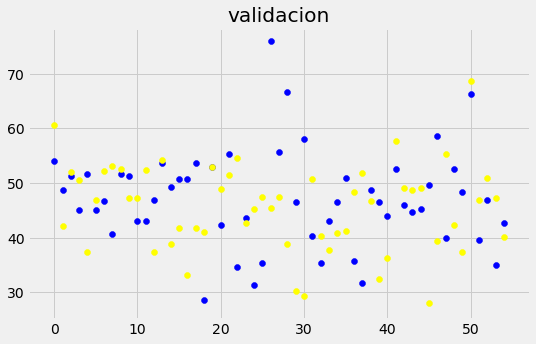

In [20]:
# función para definir modelo de predicción
def baseline_model():
    model = Sequential()
    model.add(Dense(64, input_dim=2, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# inicilizar semilla para mezcla de datos
seed=1
# incializar el modelo de regresion y definir hiperparametros
estimator_egg = KerasRegressor(build_fn=baseline_model, epochs=100, batch_size=10, verbose=False)
# inicializar validación cruzada
kfold = KFold(n_splits=10, random_state=seed)
# obtención de resultados obtenidos por el estimador
results_egg = cross_val_score(estimator_egg, x_egg, y_egg, cv=kfold)
# imprimir resultados
print("Results: %.2f (%.2f) MSE" % (results_egg.mean(), results_egg.std()))

# entrenar datos 
estimator_egg.fit(x_egg, y_egg)
# predecir datos 
prediction_egg = estimator_egg.predict(x_egg)

# graficar datos de validación 
# estilo del plot
plt.style.use('fivethirtyeight') 

plt.rcParams['figure.figsize'] = (8, 5)
plt.style.use('fast')

print( len(results_egg) )
plt.scatter(range(len(y_egg)),y_egg,c='b')
plt.scatter(range(len(prediction_egg)),prediction_egg,c='yellow')
plt.title('validacion')
plt.show()

#### Predicción de PSUB

In [21]:
# descartar valores de PSUB y PTP en la tabla general para los predictores
x_sub = Patients.drop(['PSUB','PTP','type'], axis=1).values   
# tomar valores de PSUB en la tabla  general para las etiquetas
y_sub = Patients['PSUB'].values
#x = StandardScaler().fit_transform(x) # Scale the data with `StandardScaler`

# mostrar tamaño de datos de entrada y salida
x_sub.shape
y_sub.shape

(55, 3)

(55,)

Results: -6.98 (12.38) MSE


10


Text(0.5, 1.0, 'validacion')

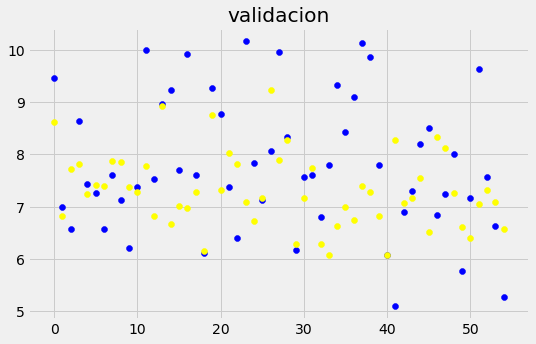

In [22]:
# función para definir modelo de predicción
def baseline_model():
    model = Sequential()
    model.add(Dense(64, input_dim=3, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adagrad')
    return model

# inicilizar semilla para mezcla de datos
seed=1
# incializar el modelo de regresion y definir hiperparametros
estimator_sub = KerasRegressor(build_fn=baseline_model, epochs=100, batch_size=10, verbose=False)
# inicializar validación cruzada
kfold = KFold(n_splits=10, random_state=seed)
# obtención de resultados obtenidos por el estimador
results_sub = cross_val_score(estimator_sub, x_sub, y_sub, cv=kfold)
# imprimir resultados
print("Results: %.2f (%.2f) MSE" % (results_sub.mean(), results_sub.std()))

# entrenar datos 
estimator_sub.fit(x_sub, y_sub)
# predecir datos 
prediction_sub = estimator_sub.predict(x_sub)

# graficar datos de validación 
# estilo del plot
plt.style.use('fivethirtyeight') 

plt.rcParams['figure.figsize'] = (8, 5)
plt.style.use('fast')

print( len(results_sub) )
plt.scatter(range(len(y_sub)),y_sub,c='b')
plt.scatter(range(len(prediction_sub)),prediction_sub,c='yellow')
plt.title('validacion')
plt.show()

#### Predicción de PTP

In [23]:
# descartar valores de PTP en la tabla general para los predictores
x_ptp = Patients.drop(['PTP','type'], axis=1).values 
# tomar valores de PTP en la tabla  general para las etiquetas
y_ptp = Patients['PTP'].values 
#x = StandardScaler().fit_transform(x) # Scale the data with `StandardScaler`

# mostrar tamaño de datos de entrada y salida
x_ptp.shape
y_ptp.shape

(55, 4)

(55,)

Results: -3.75 (9.25) MSE


10


Text(0.5, 1.0, 'validacion')

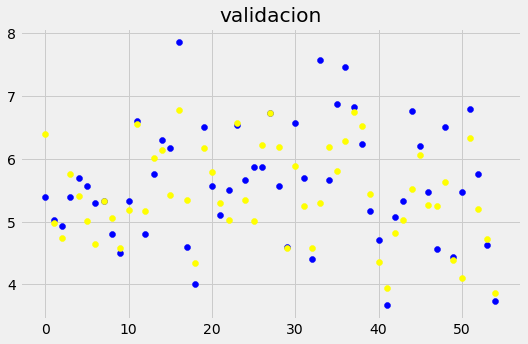

In [24]:
# función para definir modelo de predicción
def baseline_model():
    model = Sequential()
    model.add(Dense(64, input_dim=4, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adagrad')
    return model

# inicilizar semilla para mezcla de datos
seed=1
# incializar el modelo de regresion y definir hiperparametros
estimator_ptp = KerasRegressor(build_fn=baseline_model, epochs=100, batch_size=10, verbose=False)
# inicializar validación cruzada
kfold = KFold(n_splits=10, random_state=seed)
# obtención de resultados obtenidos por el estimador
results_ptp = cross_val_score(estimator_ptp, x_ptp, y_ptp, cv=kfold)
# imprimir resultados
print("Results: %.2f (%.2f) MSE" % (results_ptp.mean(), results_ptp.std()))

# entrenar datos 
estimator_ptp.fit(x_ptp, y_ptp)
# predecir datos 
prediction_ptp = estimator_ptp.predict(x_ptp)

# graficar datos de validación 
# estilo del plot
plt.style.use('fivethirtyeight') 

plt.rcParams['figure.figsize'] = (8, 5)
plt.style.use('fast')

print( len(results_ptp) )
plt.scatter(range(len(y_ptp)),y_ptp,c='b')
plt.scatter(range(len(prediction_ptp)),prediction_ptp,c='yellow')
plt.title('validacion')
plt.show()

### Clasificación de voces Hipo / Hiper

In [25]:
# descartar valores de type en la tabla general para los predictores
x = Patients.drop('type', axis=1).values   #
# tomar valores de PTP en la tabla  general para las etiquetas
y = Patients['type'].values
# mostrar tamaño de datos de entrada y salida
x.shape
y.shape

(55, 5)

(55,)

In [26]:
# Dividir los datos en datos de entrenamiento y prueba
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.10, random_state=15)

# Normalizar los datos de entrada
# definir la escala
scaler = StandardScaler().fit(x_train) # Definir factor de escala
# escala para el set de entrenamiento
x_train = scaler.transform(x_train)
# Escala para el set de prueba
x_test = scaler.transform(x_test)

In [27]:
# inicialización del modelo
model = Sequential()
# agregar las capas y la función de activacion
model.add(Dense(64, activation='relu', input_shape=(5,)))# capa de entrada
model.add(Dense(128, activation='relu'))# capa oculta
model.add(Dense(1, activation='sigmoid'))# capa de salida

# hiperparametros de compilación
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# entrenamiento del modelo
model.fit(x_train, y_train, epochs=40, batch_size=1, verbose=0)

In [28]:
# calular predicción 
y_pred = model.predict(x_test).round()
# visualizar resultados
y_pred[:50]
y_test[:50]

array([[0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.]], dtype=float32)

array([0, 0, 1, 1, 0, 1], dtype=int64)

In [29]:
# evaluacion del desempeño con metricas
precision_score(y_test, y_pred)
# calculo de recall - Sensibilidad
recall_score(y_test, y_pred)
# cálculo del F1 Score
f1_score(y_test, y_pred)
print(classification_report(y_test, y_pred))

0.6666666666666666

0.6666666666666666

0.6666666666666666

              precision    recall  f1-score   support

           0       0.67      0.67      0.67         3
           1       0.67      0.67      0.67         3

    accuracy                           0.67         6
   macro avg       0.67      0.67      0.67         6
weighted avg       0.67      0.67      0.67         6



### Mejoramiento del desempeño (Tunning usando Grid search y Random search)

In [32]:
def create_model(optimizer='adam'):
    # create model
    model = Sequential()
    model.add(Dense(64, input_dim=5, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss=keras.losses.logcosh, optimizer=optimizer, metrics=['accuracy'])
    return model


# create model
model = KerasClassifier(build_fn=create_model, epochs=40, batch_size=1, verbose=1)

# define the grid search parameters
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
param_grid = dict(optimizer=optimizer)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(x_train, y_train, validation_data=(x_test, y_test),verbose=0)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
y_pred = grid_result.predict(x_test).round()
y_test = y_test

print(grid_result.cv_results_.keys())

C:\Users\Anfeguar\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best: 0.551020 using {'optimizer': 'Adadelta'}
0.448980 (0.086319) with: {'optimizer': 'SGD'}
0.448980 (0.037061) with: {'optimizer': 'RMSprop'}
0.489796 (0.052412) with: {'optimizer': 'Adagrad'}
0.551020 (0.080471) with: {'optimizer': 'Adadelta'}
0.448980 (0.037061) with: {'optimizer': 'Adam'}
0.489796 (0.014000) with: {'optimizer': 'Adamax'}
0.469388 (0.065689) with: {'optimizer': 'Nadam'}
6/6 [==============================] - 0s 23ms/step
dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_optimizer', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])


Text(0.5, 1.0, 'validacion')

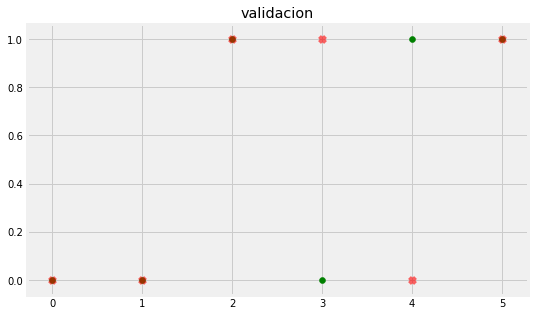

In [33]:
import matplotlib.pylab as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 5)
plt.style.use('fast')

plt.scatter(range(len(y_pred)),y_pred,c='g')
plt.scatter(range(len(y_test)),y_test,c='r', alpha=0.6, marker = 'x')
plt.title('validacion')
plt.show()
K.clear_session()

### Tunning de optimizadores usando Random Search

In [34]:
def create_model(optimizer='adam'):
    # create model
    model = Sequential()
    model.add(Dense(64, input_dim=5, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss=keras.losses.logcosh, optimizer=optimizer, metrics=['accuracy'])
    return model

# create model
model = KerasClassifier(build_fn=create_model, epochs=40, batch_size=1, verbose=0)

# define the grid search parameters
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
param_grid = dict(optimizer=optimizer)
rsearch = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=100,n_jobs=-1, cv=3)
rsearch_result = rsearch.fit(x_train, y_train, validation_data=(x_test, y_test),verbose=0)

# summarize results
print("Best: %f using %s" % (rsearch_result.best_score_, rsearch_result.best_params_))
means = rsearch_result.cv_results_['mean_test_score']
stds = rsearch_result.cv_results_['std_test_score']
params = rsearch_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
y_pred = rsearch_result.predict(x_test).round()
y_test = y_test

print(rsearch_result.cv_results_.keys())


C:\Users\Anfeguar\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:266: UserWarning: The total space of parameters 7 is smaller than n_iter=100. Running 7 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
C:\Users\Anfeguar\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best: 0.489796 using {'optimizer': 'Adadelta'}
0.387755 (0.053453) with: {'optimizer': 'SGD'}
0.469388 (0.025269) with: {'optimizer': 'RMSprop'}
0.469388 (0.025269) with: {'optimizer': 'Adagrad'}
0.489796 (0.038360) with: {'optimizer': 'Adadelta'}
0.448980 (0.037061) with: {'optimizer': 'Adam'}
0.489796 (0.038360) with: {'optimizer': 'Adamax'}
0.448980 (0.115665) with: {'optimizer': 'Nadam'}
dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_optimizer', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])


Text(0.5, 1.0, 'validacion')

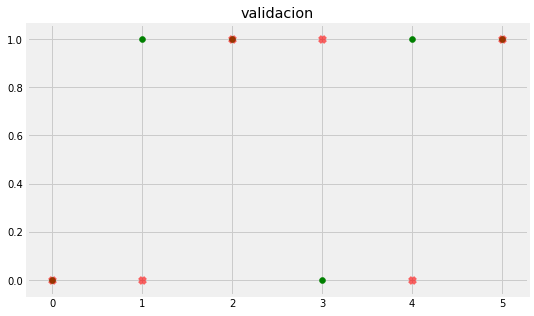

In [35]:
import matplotlib.pylab as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 5)
plt.style.use('fast')

plt.scatter(range(len(y_pred)),y_pred,c='g')
plt.scatter(range(len(y_test)),y_test,c='r', alpha=0.6,marker = 'x')
plt.title('validacion')
plt.show()
K.clear_session()

<BarContainer object of 2 artists>

Text(0.5, 1.0, 'Grid search vs random search (funciones de optimización)')

Text(0, 0.5, 'Best score')

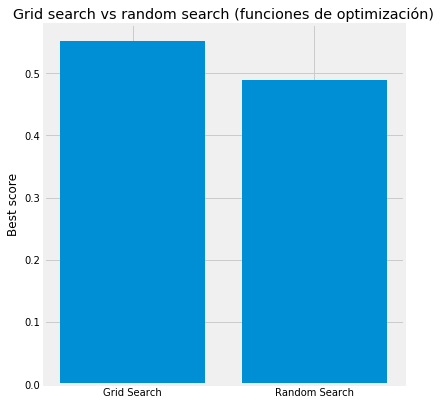

In [36]:
fig = plt.figure(figsize=[10, 5])
ax = fig.add_axes([0,0,0.5,1])
opt = ['Grid Search', 'Random Search']
students = [grid_result.best_score_,rsearch_result.best_score_]
ax.bar(opt,students)

plt.title('Grid search vs random search (funciones de optimización)')
plt.ylabel('Best score')
plt.show()

### Tunning de Batch size y Epoch usando Grid Search

In [37]:
def create_model():
    # create model
    model = Sequential()
    model.add(Dense(64, input_dim=5, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss=keras.losses.logcosh, optimizer='nadam', metrics=['accuracy'])
    return model

# create model
model = KerasClassifier(build_fn=create_model, verbose=0)

# define the grid search parameters
batch_size = [10, 20, 40, 60, 80, 100]
epochs = [10, 50, 100]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(x_train, y_train, validation_data=(x_test, y_test), verbose=0)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
y_pred = grid_result.predict(x_test).round()
y_test = y_test

print(grid_result.cv_results_.keys())

C:\Users\Anfeguar\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
C:\Users\Anfeguar\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best: 0.530612 using {'batch_size': 80, 'epochs': 50}
0.428571 (0.073499) with: {'batch_size': 10, 'epochs': 10}
0.510204 (0.038360) with: {'batch_size': 10, 'epochs': 50}
0.448980 (0.115665) with: {'batch_size': 10, 'epochs': 100}
0.489796 (0.038360) with: {'batch_size': 20, 'epochs': 10}
0.469388 (0.025269) with: {'batch_size': 20, 'epochs': 50}
0.448980 (0.069999) with: {'batch_size': 20, 'epochs': 100}
0.346939 (0.142266) with: {'batch_size': 40, 'epochs': 10}
0.469388 (0.043750) with: {'batch_size': 40, 'epochs': 50}
0.489796 (0.062229) with: {'batch_size': 40, 'epochs': 100}
0.428571 (0.073499) with: {'batch_size': 60, 'epochs': 10}
0.489796 (0.038360) with: {'batch_size': 60, 'epochs': 50}
0.510204 (0.071749) with: {'batch_size': 60, 'epochs': 100}
0.326531 (0.116515) with: {'batch_size': 80, 'epochs': 10}
0.530612 (0.090230) with: {'batch_size': 80, 'epochs': 50}
0.469388 (0.065689) with: {'batch_size': 80, 'epochs': 100}
0.408163 (0.116404) with: {'batch_size': 100, 'epochs': 

Text(0.5, 1.0, 'validacion')

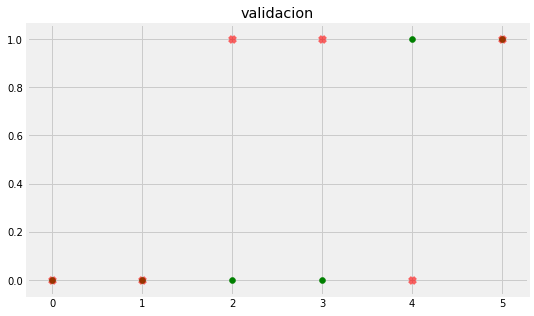

In [38]:
import matplotlib.pylab as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 5)
plt.style.use('fast')

plt.scatter(range(len(y_pred)),y_pred,c='g')
plt.scatter(range(len(y_test)),y_test,c='r', alpha=0.6,marker = 'x')
plt.title('validacion')
plt.show()
K.clear_session()

### Tunning de Batch size y Epoch usando Random Search

In [39]:
def create_model():
    # create model
    model = Sequential()
    model.add(Dense(64, input_dim=5, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss=keras.losses.logcosh, optimizer='nadam', metrics=['accuracy'])
    return model

# create model
model = KerasClassifier(build_fn=create_model, verbose=0)

# define the grid search parameters
batch_size = [10, 20, 40, 60, 80, 100]
epochs = [10, 50, 100]
param_grid = dict(batch_size=batch_size, epochs=epochs)
rsearch = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=100, n_jobs=-1, cv=3)
rsearch_result = rsearch.fit(x_train, y_train, validation_data=(x_test, y_test))

# summarize results
print("Best: %f using %s" % (rsearch_result.best_score_, rsearch_result.best_params_))
means = rsearch_result.cv_results_['mean_test_score']
stds = rsearch_result.cv_results_['std_test_score']
params = rsearch_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
y_pred = rsearch_result.predict(x_test).round()
y_test = y_test

print(rsearch_result.cv_results_.keys())

C:\Users\Anfeguar\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:266: UserWarning: The total space of parameters 18 is smaller than n_iter=100. Running 18 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
C:\Users\Anfeguar\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best: 0.551020 using {'epochs': 50, 'batch_size': 20}
0.448980 (0.015750) with: {'epochs': 10, 'batch_size': 10}
0.510204 (0.087744) with: {'epochs': 50, 'batch_size': 10}
0.469388 (0.152143) with: {'epochs': 100, 'batch_size': 10}
0.387755 (0.065443) with: {'epochs': 10, 'batch_size': 20}
0.551020 (0.052906) with: {'epochs': 50, 'batch_size': 20}
0.510204 (0.137399) with: {'epochs': 100, 'batch_size': 20}
0.367347 (0.090628) with: {'epochs': 10, 'batch_size': 40}
0.489796 (0.101981) with: {'epochs': 50, 'batch_size': 40}
0.510204 (0.087744) with: {'epochs': 100, 'batch_size': 40}
0.428571 (0.039694) with: {'epochs': 10, 'batch_size': 60}
0.530612 (0.066821) with: {'epochs': 50, 'batch_size': 60}
0.408163 (0.112470) with: {'epochs': 100, 'batch_size': 60}
0.346939 (0.117738) with: {'epochs': 10, 'batch_size': 80}
0.489796 (0.038360) with: {'epochs': 50, 'batch_size': 80}
0.448980 (0.086319) with: {'epochs': 100, 'batch_size': 80}
0.346939 (0.093596) with: {'epochs': 10, 'batch_size': 1

Text(0.5, 1.0, 'validacion')

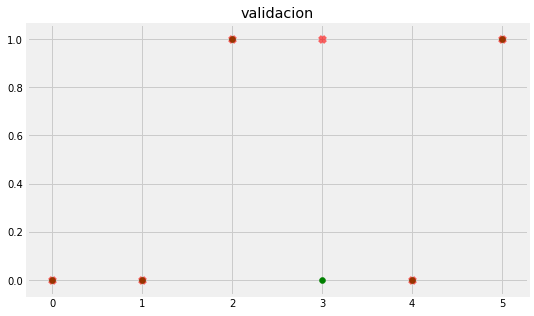

In [40]:
import matplotlib.pylab as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 5)
plt.style.use('fast')

plt.scatter(range(len(y_pred)),y_pred,c='g')
plt.scatter(range(len(y_test)),y_test,c='r', alpha=0.6,marker = 'x')
plt.title('validacion')
plt.show()
K.clear_session()

<BarContainer object of 2 artists>

Text(0.5, 1.0, 'Grid search vs random search (epocas y batch size)')

Text(0, 0.5, 'Best score')

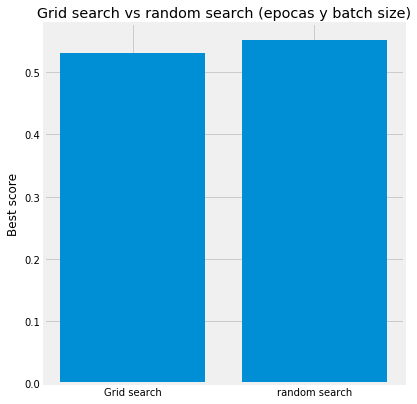

In [41]:
fig = plt.figure(figsize=[10, 5])
ax = fig.add_axes([0,0,0.5,1])
opt = ['Grid search', 'random search']
students = [grid_result.best_score_,rsearch_result.best_score_]
ax.bar(opt,students)

plt.title('Grid search vs random search (epocas y batch size)')
plt.ylabel('Best score')
plt.show()

### Tunning de Learning rate usando Grid Search

In [42]:
def create_model(learn_rate=0.01):
    # create model
    model = Sequential()
    model.add(Dense(64, input_dim=5, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    nadam = keras.optimizers.Nadam(learning_rate=learn_rate, beta_1=0.9, beta_2=0.9)
    model.compile(loss=keras.losses.logcosh, optimizer=nadam, metrics=['accuracy'])
    return model

# create model
model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=10, verbose=1)

# define the grid search parameters
learn_rate = [0.01, 0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1]
param_grid = dict(learn_rate=learn_rate)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(x_train, y_train, validation_data=(x_test, y_test), verbose=0)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
y_pred = grid_result.predict(x_test).round()
y_test = y_test

print(grid_result.cv_results_.keys())

C:\Users\Anfeguar\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
C:\Users\Anfeguar\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best: 0.591837 using {'learn_rate': 0.06}
0.469388 (0.042000) with: {'learn_rate': 0.01}
0.469388 (0.025269) with: {'learn_rate': 0.02}
0.448980 (0.069999) with: {'learn_rate': 0.03}
0.367347 (0.041059) with: {'learn_rate': 0.04}
0.367347 (0.010500) with: {'learn_rate': 0.05}
0.591837 (0.086876) with: {'learn_rate': 0.06}
0.469388 (0.088552) with: {'learn_rate': 0.07}
0.346939 (0.025630) with: {'learn_rate': 0.08}
0.387755 (0.128793) with: {'learn_rate': 0.09}
0.387755 (0.102520) with: {'learn_rate': 0.1}
6/6 [==============================] - 0s 21ms/step
dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_learn_rate', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])


Text(0.5, 1.0, 'validacion')

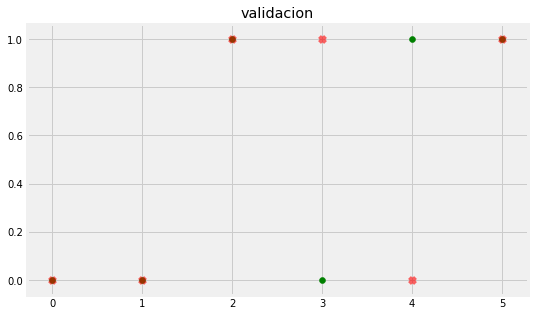

In [43]:
plt.rcParams['figure.figsize'] = (8, 5)
plt.style.use('fast')

plt.scatter(range(len(y_pred)),y_pred,c='g')
plt.scatter(range(len(y_test)),y_test,c='r', alpha=0.6,marker = 'x')
plt.title('validacion')
plt.show()
K.clear_session()

### Tunning de Learning rate usando Random Search

In [44]:
def create_model(learn_rate=0.01):
    # create model
    model = Sequential()
    model.add(Dense(64, input_dim=5, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    nadam = keras.optimizers.Nadam(learning_rate=learn_rate, beta_1=0.9, beta_2=0.9)
    model.compile(loss=keras.losses.logcosh, optimizer=nadam, metrics=['accuracy'])
    return model

# create model
model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=10, verbose=1)

# define the grid search parameters
learn_rate = [0.01, 0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1]
param_grid = dict(learn_rate=learn_rate)
rsearch = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=100, n_jobs=-1, cv=3)
rsearch_result = rsearch.fit(x_train, y_train, validation_data=(x_test, y_test), verbose=0)

# summarize results
print("Best: %f using %s" % (rsearch_result.best_score_, rsearch_result.best_params_))
means = rsearch_result.cv_results_['mean_test_score']
stds = rsearch_result.cv_results_['std_test_score']
params = rsearch_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
y_pred = rsearch_result.predict(x_test).round()
y_test = y_test

print(rsearch_result.cv_results_.keys())

C:\Users\Anfeguar\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:266: UserWarning: The total space of parameters 10 is smaller than n_iter=100. Running 10 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
C:\Users\Anfeguar\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best: 0.571429 using {'learn_rate': 0.1}
0.469388 (0.043750) with: {'learn_rate': 0.01}
0.469388 (0.042000) with: {'learn_rate': 0.02}
0.387755 (0.065443) with: {'learn_rate': 0.03}
0.448980 (0.037061) with: {'learn_rate': 0.04}
0.469388 (0.127749) with: {'learn_rate': 0.05}
0.408163 (0.025390) with: {'learn_rate': 0.06}
0.530612 (0.042000) with: {'learn_rate': 0.07}
0.510204 (0.170536) with: {'learn_rate': 0.08}
0.428571 (0.060634) with: {'learn_rate': 0.09}
0.571429 (0.124925) with: {'learn_rate': 0.1}
6/6 [==============================] - 0s 44ms/step
dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_learn_rate', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])


Text(0.5, 1.0, 'validacion')

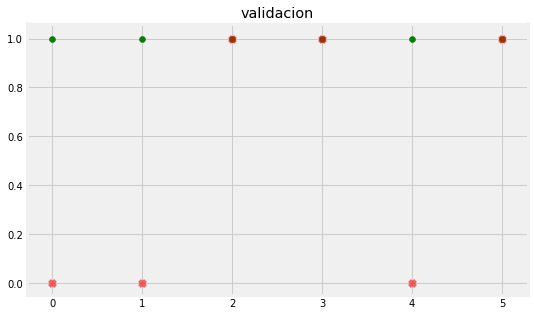

In [45]:
plt.rcParams['figure.figsize'] = (8, 5)
plt.style.use('fast')

plt.scatter(range(len(y_pred)),y_pred,c='g')
plt.scatter(range(len(y_test)),y_test,c='r', alpha=0.6,marker = 'x')
plt.title('validacion')
plt.show()
K.clear_session()

<BarContainer object of 2 artists>

Text(0.5, 1.0, 'Grid search vs random search (learning rate)')

Text(0, 0.5, 'Best score')

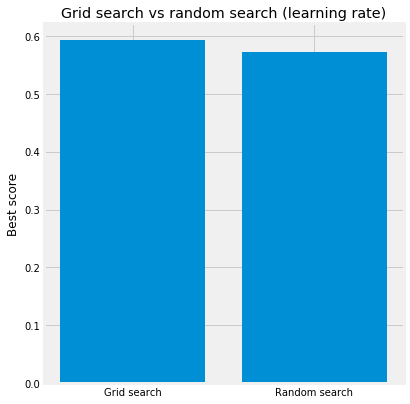

In [46]:
fig = plt.figure(figsize=[10, 5])
ax = fig.add_axes([0,0,0.5,1])
opt = ['Grid search', 'Random search']
students = [grid_result.best_score_,rsearch_result.best_score_]
ax.bar(opt,students)

plt.title('Grid search vs random search (learning rate)')
plt.ylabel('Best score')
plt.show()

### Tuning de numero de neuronas de la capa oculta Grid Search

In [47]:
def create_model(neuronas1=1,neuronas2=1):
    # create model
    model = Sequential()
    model.add(Dense(neuronas1, input_dim=5, activation='relu'))
    model.add(Dense(neuronas2, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    nadam = keras.optimizers.Nadam(learning_rate=0.35, beta_1=0.9, beta_2=0.9)
    model.compile(loss=keras.losses.logcosh, optimizer=nadam, metrics=['accuracy'])
    return model

# create model
model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=10, verbose=1)

# define the grid search parameters
neuronas1 = [20, 40, 60, 80, 100, 120]
neuronas2 = [20, 40, 60, 80, 100, 120]
param_grid = dict(neuronas1=neuronas1,neuronas2=neuronas2)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(x_train, y_train, validation_data=(x_test, y_test), verbose=0)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
y_pred = grid_result.predict(x_test).round()
y_test = y_test

print(grid_result.cv_results_.keys())

C:\Users\Anfeguar\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
C:\Users\Anfeguar\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best: 0.551020 using {'neuronas1': 20, 'neuronas2': 100}
0.448980 (0.069999) with: {'neuronas1': 20, 'neuronas2': 20}
0.428571 (0.060634) with: {'neuronas1': 20, 'neuronas2': 40}
0.367347 (0.101559) with: {'neuronas1': 20, 'neuronas2': 60}
0.367347 (0.101559) with: {'neuronas1': 20, 'neuronas2': 80}
0.551020 (0.163045) with: {'neuronas1': 20, 'neuronas2': 100}
0.367347 (0.101559) with: {'neuronas1': 20, 'neuronas2': 120}
0.367347 (0.101559) with: {'neuronas1': 40, 'neuronas2': 20}
0.367347 (0.101559) with: {'neuronas1': 40, 'neuronas2': 40}
0.367347 (0.101559) with: {'neuronas1': 40, 'neuronas2': 60}
0.367347 (0.101559) with: {'neuronas1': 40, 'neuronas2': 80}
0.367347 (0.101559) with: {'neuronas1': 40, 'neuronas2': 100}
0.367347 (0.101559) with: {'neuronas1': 40, 'neuronas2': 120}
0.326531 (0.152741) with: {'neuronas1': 60, 'neuronas2': 20}
0.469388 (0.164238) with: {'neuronas1': 60, 'neuronas2': 40}
0.367347 (0.101559) with: {'neuronas1': 60, 'neuronas2': 60}
0.469388 (0.164238) with

Text(0.5, 1.0, 'validacion')

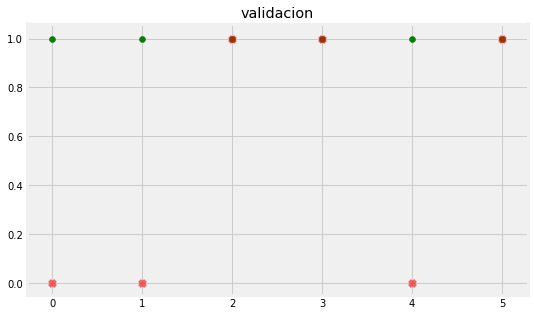

In [48]:
plt.rcParams['figure.figsize'] = (8, 5)
plt.style.use('fast')

plt.scatter(range(len(y_pred)),y_pred,c='g')
plt.scatter(range(len(y_test)),y_test,c='r', alpha=0.6,marker = 'x')
plt.title('validacion')
plt.show()
K.clear_session()

### Tuning de numero de neuronas de la capa oculta Random Search

In [49]:
def create_model(neuronas1=1,neuronas2=1):
    # create model
    model = Sequential()
    model.add(Dense(neuronas1, input_dim=5, activation='relu'))
    model.add(Dense(neuronas2, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    nadam = keras.optimizers.Nadam(learning_rate=0.35, beta_1=0.9, beta_2=0.9)
    model.compile(loss=keras.losses.logcosh, optimizer=nadam, metrics=['accuracy'])
    return model

# create model
model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=10, verbose=1)

# define the grid search parameters
neuronas1 = [10, 20, 30]
neuronas2 = [10, 20, 30]
param_grid = dict(neuronas1=neuronas1,neuronas2=neuronas2)
rsearch = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=100, n_jobs=-1, cv=3)
rsearch_result = rsearch.fit(x_train, y_train, validation_data=(x_test, y_test))

# summarize results
print("Best: %f using %s" % (rsearch_result.best_score_, rsearch_result.best_params_))
means = rsearch_result.cv_results_['mean_test_score']
stds = rsearch_result.cv_results_['std_test_score']
params = rsearch_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
y_pred = rsearch_result.predict(x_test).round()
y_test = y_test

print(rsearch_result.cv_results_.keys())

C:\Users\Anfeguar\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:266: UserWarning: The total space of parameters 9 is smaller than n_iter=100. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
C:\Users\Anfeguar\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Train on 49 samples, validate on 6 samples
Epoch 1/10
49/49 [==============================] - 4s 72ms/step - loss: 0.2261 - accuracy: 0.4694 - val_loss: 0.2169 - val_accuracy: 0.5000
Epoch 2/10
49/49 [==============================] - 0s 674us/step - loss: 0.2372 - accuracy: 0.4490 - val_loss: 0.2169 - val_accuracy: 0.5000
Epoch 3/10
49/49 [==============================] - 0s 837us/step - loss: 0.2695 - accuracy: 0.3673 - val_loss: 0.2889 - val_accuracy: 0.3333
Epoch 4/10
49/49 [==============================] - 0s 694us/step - loss: 0.2327 - accuracy: 0.4490 - val_loss: 0.2169 - val_accuracy: 0.5000
Epoch 5/10
49/49 [==============================] - 0s 551us/step - loss: 0.1948 - accuracy: 0.5510 - val_loss: 0.2169 - val_accuracy: 0.5000
Epoch 6/10
49/49 [==============================] - 0s 551us/step - loss: 0.1948 - accuracy: 0.5510 - val_loss: 0.2169 - val_accuracy: 0.5000
Epoch 7/10
49/49 [==============================] - 0s 571us/step - loss: 0.1949 - accuracy: 0.5510 - val_

Text(0.5, 1.0, 'validacion')

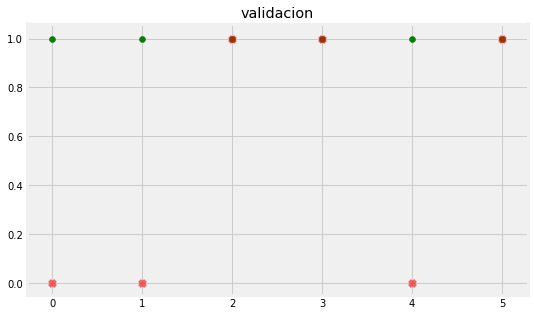

In [50]:
plt.rcParams['figure.figsize'] = (8, 5)
plt.style.use('fast')

plt.scatter(range(len(y_pred)),y_pred,c='g')
plt.scatter(range(len(y_test)),y_test,c='r', alpha=0.6,marker = 'x')
plt.title('validacion')
plt.show()
K.clear_session()

<BarContainer object of 2 artists>

Text(0.5, 1.0, 'Grid search vs random search (Num neuronas)')

Text(0, 0.5, 'Best score')

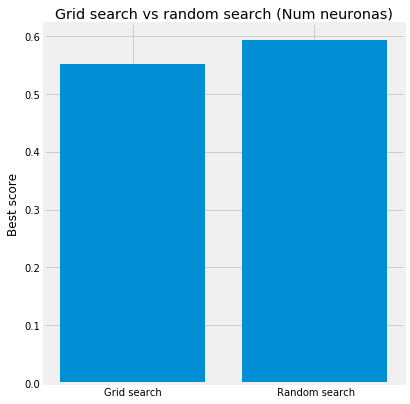

In [51]:
fig = plt.figure(figsize=[10, 5])
ax = fig.add_axes([0,0,0.5,1])
opt = ['Grid search', ' Random search']
students = [grid_result.best_score_,rsearch_result.best_score_]
ax.bar(opt,students)

plt.title('Grid search vs random search (Num neuronas)')
plt.ylabel('Best score')
plt.show()

### Red neuronal para detección de voces Hiper / Hipo funcionales a partir de la voz (parametros optimizados)

In [30]:
# definir parametros del optimizador
adadelta=keras.optimizers.Adadelta(learning_rate=0.1, rho=0.95, epsilon=1e-07)
# inicialización del modelo
model = Sequential()
# agregar las capas y la función de activacion
model.add(Dense(80, activation='relu', input_shape=(5,)))# capa de entrada
model.add(Dense(100, activation='relu'))# capa oculta
model.add(Dense(1, activation='sigmoid'))# capa de salida

# hiperparametros de compilación
model.compile(loss='binary_crossentropy', optimizer=adadelta, metrics=['accuracy'])

# entrenamiento del modelo
model.fit(x_train, y_train, epochs=50, batch_size=40, verbose=0)

In [31]:
# calular predicción 
y_pred = model.predict(x_test).round()
# visualizar resultados
y_pred[:5]
y_test[:5]

array([[1.],
       [0.],
       [1.],
       [0.],
       [0.]], dtype=float32)

array([0, 0, 1, 1, 0], dtype=int64)

In [32]:
# valores obtenidos por procesamiento de la señal de entrada (audio)
val_cepstrum
val_HNR

14.354366335657595

15.613104593608966

In [33]:
# predicción de EGG
pred_egg = estimator_egg.predict(np.array([[val_cepstrum,val_HNR]]))
pred_egg = float(pred_egg)
print("predicción de EGG = %f" % (pred_egg))

# predicción de SUB
pred_sub = estimator_sub.predict(np.array([[pred_egg,val_cepstrum,val_HNR]]))
pred_sub = float(pred_sub)
print("predicción de SUB = %f" % (pred_sub))

# predicción de SUB
pred_ptp = estimator_ptp.predict(np.array([[pred_egg,pred_sub,val_cepstrum,val_HNR]]))
pred_ptp = float(pred_ptp)
print("predicción de PTP = %f" % (pred_ptp))

predicción de EGG = 36.296963
predicción de SUB = 5.646165
predicción de PTP = 4.041154


In [36]:
# predicción de voz hiper o hipo funcional
hiper_hipo=scaler.transform(np.array([[pred_egg,pred_sub,pred_ptp,val_cepstrum,val_HNR]]))
hiper_hipo = model.predict(hiper_hipo).round()

if (hiper_hipo==1):
    print("La predicción de voz es hiperfuncional, valor = %f" % (int(hiper_hipo)))
else:
    print("La predicción de voz es hipofuncional, valor = %f" % (int(hiper_hipo)))

La predicción de voz es hipofuncional, valor = 0.000000
